In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks on a frame to get and refine _masklets_ (spatio-temporal masks) 
- propagating clicks to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

If running locally using jupyter, first install `segment-anything-2` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything-2#installation) in the repository.

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
os.environ['CUDA_VISIBLE_DEVICES']="1"

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [4]:
import torch 
print(torch.__version__)

2.4.1+cu118


In [5]:
from sam2.build_sam import build_sam2_video_predictor

# sam2_checkpoint = "./checkpoints/sam2.1_hiera_small.pt"
sam2_checkpoint = "./checkpoints/sam2.1_hiera_s_ioct.pt"

model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

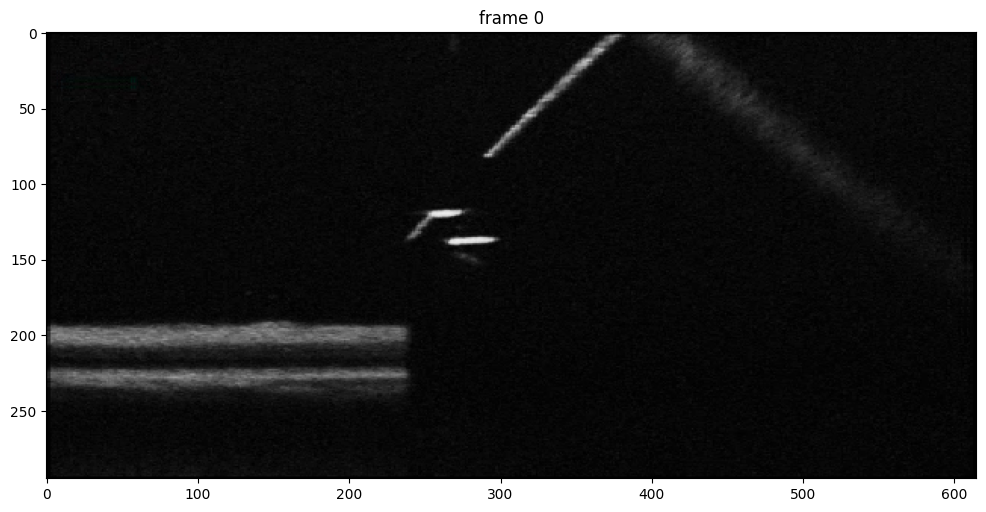

In [7]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./datasets/iOCT_raw/valid/JPEGImages/seq_6"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", '.png']
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [8]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 40/40 [00:00<00:00, 124.17it/s]
d:\Code\work\ioctVideo\iOCTSAM2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [9]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

d:\Code\work\ioctVideo\iOCTSAM2\sam2\sam2_video_predictor.py:799: UserWarning: cannot import name '_C' from 'sam2' (d:\Code\work\ioctVideo\iOCTSAM2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


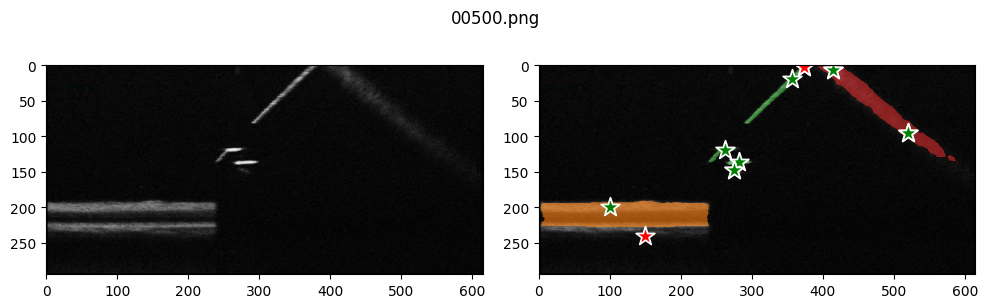

In [10]:
prompts = {}
ann_frame_idx = 0  # the frame index we interact with


# ----------------- annotate the tissue -----------------
ann_obj_id = 1
points = np.array([[100, 200], [150, 240]], dtype=np.float32)
labels = np.array([1, 0], np.int32)

prompts[ann_obj_id] = points, labels

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# ----------------- annotate the tool -----------------
ann_obj_id = 2
points = np.array([[262, 120], [282, 137], [356, 19]], dtype=np.float32)
labels = np.array([1, 1, 1], np.int32)

prompts[ann_obj_id] = points, labels

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# ----------------- annotate artifacts -----------------
ann_obj_id = 3
points = np.array([[414, 7], [520, 95], [275, 147], [374, 3]], dtype=np.float32)
labels = np.array([1, 1, 1, 0], np.int32)

prompts[ann_obj_id] = points, labels

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# ----------------- show the results on the first frame -----------------
# show the results on the current (interacted) frame on all objects
fig_size = (10, 3)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

axs[0].imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

axs[1].imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

fig.suptitle(f"{frame_names[frame_idx]}")
plt.tight_layout()
plt.show()

#### Step 2: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [11]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    c, _, h, w = out_mask_logits.shape
    output_mask = np.zeros((1, h, w), dtype=int)
    for i, out_obj_id in enumerate(out_obj_ids):
        output_mask[(out_mask_logits[i] > 0.0).cpu()] = out_obj_id
    output_mask = np.squeeze(output_mask)
    video_segments[out_frame_idx] = output_mask

propagate in video: 100%|██████████| 40/40 [00:02<00:00, 17.79it/s]


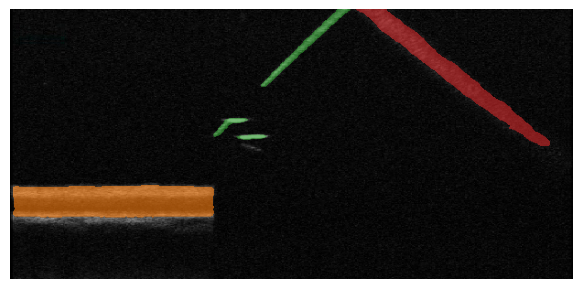

In [12]:
plot_dir = './results/demo/offline'
os.makedirs(plot_dir, exist_ok=True)

cmap = plt.get_cmap("tab10")
class_to_color = {
    1: cmap(1),
    2: cmap(2),
    3: cmap(3),
}

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
plt.figure(figsize=(6, 3))
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    output_mask = video_segments[out_frame_idx]

    colored_mask = np.zeros((output_mask.shape[0], output_mask.shape[1], 4))
    for class_id, color in class_to_color.items():
        colored_mask[output_mask == class_id] = color  # Assign the corresponding color from the colormap
    raw_image = np.array(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    plt.imshow(raw_image)
    plt.imshow(colored_mask, alpha=0.6)  # Adjust alpha to control transparency
    plt.axis('off')  # Turn off axis for cleaner display
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, frame_names[out_frame_idx]), dpi=100) if vis_frame_stride==1 else plt.show() 